# NIFITS: application to NOTT

## Perimeter
This work serves as a an exploration proof of concept to demonstrate how NIFITS models can operate with a spatial filtered photonics nuller with a double-bracewell combination. This notebook is specically dedicated to NOTT observing an exoplanet with the UTs. This file generate a simulated nifits file with SCIFYSim then calculate detection limit. 

In [67]:
# Execute this cell to load the notebook's style sheet, then ignore it.
from IPython.core.display import HTML
# css_file = '/home/romain/Downloads/numericalmoocstyle.css'
# HTML(open(css_file, 'r').read())

In [100]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as units
from astropy.table import Table
import nifits
import scifysim as sf
sf.logit.setLevel(sf.logging.ERROR)
from scifysim.dummy import makesim
from kernuller import pairwise_kernel
from kernuller.diagrams import plot_chromatic_matrix, plot_outputs_smart
from kernuller import bo
import sympy as sp
import nifits.io.oifits as io

In [69]:
# Define own path 
path = "/Users/denis/Python/astro/SCIFYsim/hackathon/"

### Creation of the VLTI NOTT array
The pupil map is created based on data provided by the consortium. It was built for the example and should not serve as reference.

In [70]:
# Define config file, mode, target and output file
config = "UT_R400_61_vir"
config_file = config + ".ini"
target = "61 Vir"
mode = "planet"
expname = mode
output_file = f"{config}_{mode}.nifits"

For (near) perfect simulation, modify the config file:
* `atmo.fc_ao` >= 20
* `atmo.correc` >= 40
* `fringe_tracker.dry_scaling` <= 1e-6
* `firnge_tracker.wet_scaleing` <= 1e-6


In [71]:
# Load config file
asim = makesim(path + config_file, target=target)

inpol = np.array(["s","s","s","s"])[None,:]
outpol = np.array(["s","s","s","s","s","s","s","s"])[None,:]

if mode == "planet":
    pass
elif mode == "disk":
    asim.combiner = sf.combiner.combiner.from_config(asim.config, ph_shifters=(0,-sp.pi/2)) # 
    asim.combiner.chromatic_matrix(asim.lambda_science_range)
elif mode == "backup-disk":
    asim.combiner = sf.combiner.combiner.from_config(asim.config, ph_shifters=(0,0))
    vec_backup = sp.exp(sp.I*sp.pi * sp.diag(0,1,0,1))
    # vec_backup2 = sp.exp(sp.I*sp.pi/2 * sp.diag(0,0,1,1))
    asim.combiner.M = sp.Matrix(asim.combiner.M@(vec_backup))
    asim.combiner.dark = np.array([False,False,True,False,False,True,False,False,])
    asim.combiner.bright = np.array([False,False,False,True,True,False,False,False,])
    

elif mode == "backup-disk+":
    asim.combiner = sf.combiner.combiner.from_config(asim.config, ph_shifters=(0,0))
    vec_backup = sp.exp(sp.I*sp.pi * sp.diag(0,1,0,1))
    vec_backup2 = sp.exp(sp.I*sp.pi/2 * sp.diag(0,0,1,1))
    asim.combiner.M = sp.Matrix(asim.combiner.M@(vec_backup*vec_backup2))
    asim.combiner.dark = np.array([False,False,True,False,True,True,False,False,])
    asim.combiner.bright = np.array([False,False,False,True,False,False,False,False,])
    

asim.combiner.chromatic_matrix(asim.lambda_science_range)
asim.point(asim.sequence[4], asim.target, refresh_array=True)

ak = pairwise_kernel(2)
myk = np.hstack((np.zeros((1,3)), ak, np.zeros((1,3))))
asim.combiner.K = myk
del ak
del myk

# fig1, axs = plot_outputs_smart(matrix = asim.combiner.Mcn[4,2:6])
# fig1.show()
# fig2, axs, matrix = plot_chromatic_matrix(asim.combiner.M,
#                                          sf.combiners.lamb, asim.lambda_science_range,
#                                          verbose=False, returnmatrix=True,minfrac=0.9,
#                                          plotout=True, show=False, title="With Tepper couplers")
# fig2.show()


ERROR-scifysim.utilities- Couldn't find the entry in JSDC catalog
Dist set to  8.505346886320083 [pc]
T set to  5915.33 [K]
R set to  0.89 [R_sun]
ERROR-scifysim.injection- Now we use fpath to provide the root for appendix config files
0.010601259160261856
(50, 3)
(150,)
sep =  60.0
pa =  90.0
offset =  (-60.0, 3.67394039744206e-15)
----------------------------------------
Switching to znse+co2
ERROR-scifysim.director- Correcting with only glass and CO2
inside_tuning [ 0.00000000e+00 -7.01042029e-08  0.00000000e+00 -7.01043881e-08] [ 0.         -0.00014691  0.         -0.00014691]
ERROR-scifysim.injection- Now we use fpath to provide the root for appendix config files
0.010601259160261856
(50, 3)
(150,)
sep =  60.0
pa =  90.0
offset =  (-60.0, 3.67394039744206e-15)
----------------------------------------
Switching to znse+co2
ERROR-scifysim.director- Correcting with only glass and CO2
inside_tuning [ 0.00000000e+00 -7.01042029e-08  0.00000000e+00 -7.01043881e-08] [ 0.         -0.00014

## Phasing and beam-combination information

In NOTT, the beam-combiner has static chromatic effects that are encoded into the `Mcn` datacube containing the beam-cobination matrix for each wavelength. This effect is compensated by an LDC static offset, which effect is stored in `g_internal`.

The leftovers from the atmospheric dispersion, conpensated with the LDC is stored in `g_atmo`.

Following the NIFITS guideline, we set aside the static contribution of `g_internal` to be factored into the beam-combiner matrix `NI_CATM`. The effects of `g_atmo` are added to 

<div class="alert alert-block alert-warning">
<b>TODO:</b> In practice, the choice of beam-combiner mode (i.e. planet vs disk mode) should fall under NI_MOD vector. But in the current setup of SCIFYsim, it would still be contained in `g_internal`, which would mean a different `NI_CATM` matrix if nothing is done. This is not very critical as long as `NI_CATM` is close.
</div>

/Users/denis/.pyenv/versions/3.12.7/lib/python3.12/site-packages/matplotlib/transforms.py:2872: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
/Users/denis/Python/astro/kernuller/kernuller/diagrams.py:408: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


removing the labels: [False False False False False False False False]


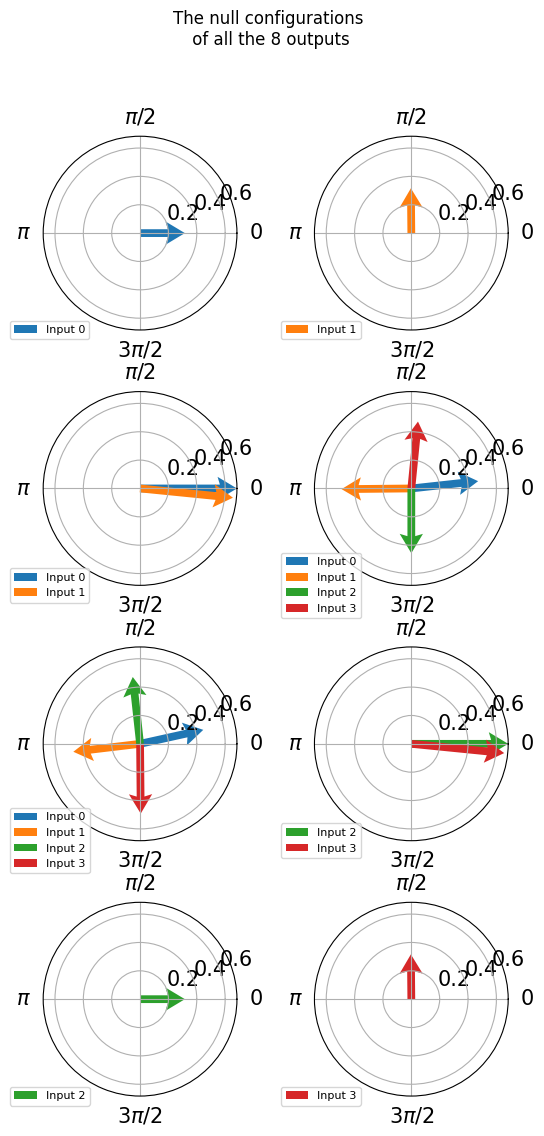

/var/folders/s8/738f03493wgdx0xlygrfh2krdpkh0r/T/ipykernel_39878/3628459892.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
/var/folders/s8/738f03493wgdx0xlygrfh2krdpkh0r/T/ipykernel_39878/3628459892.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


(6, 12.5)
(6, 12.5)
out_switch (67, 8, 4)
inarray (67, 4)



/var/folders/s8/738f03493wgdx0xlygrfh2krdpkh0r/T/ipykernel_39878/3628459892.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig3.show()


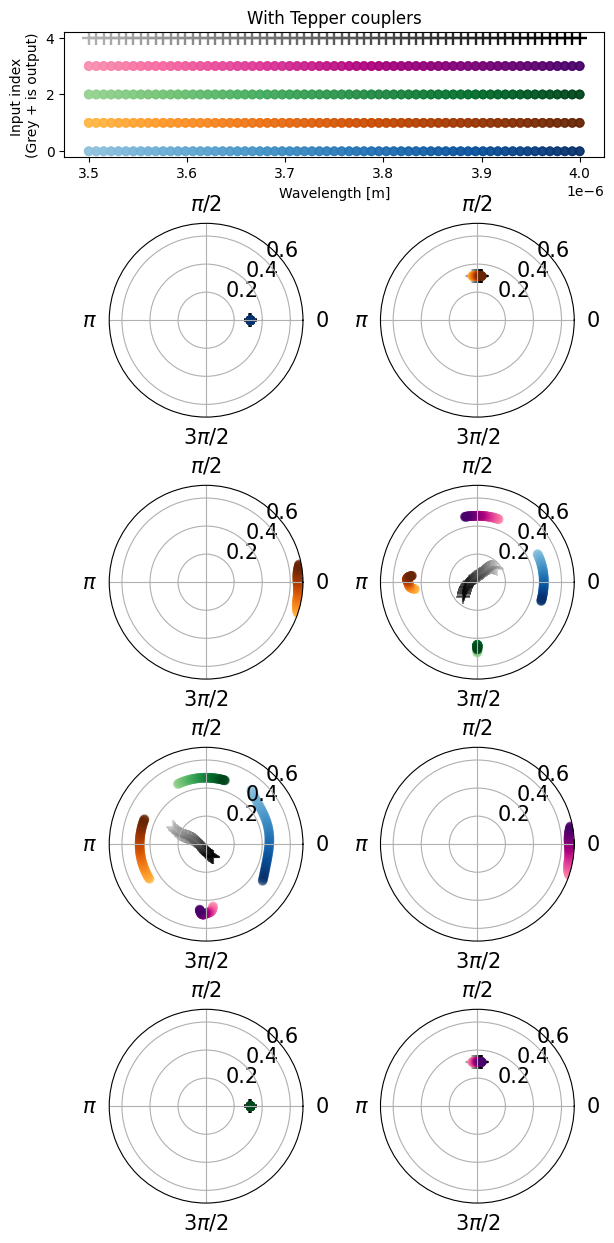

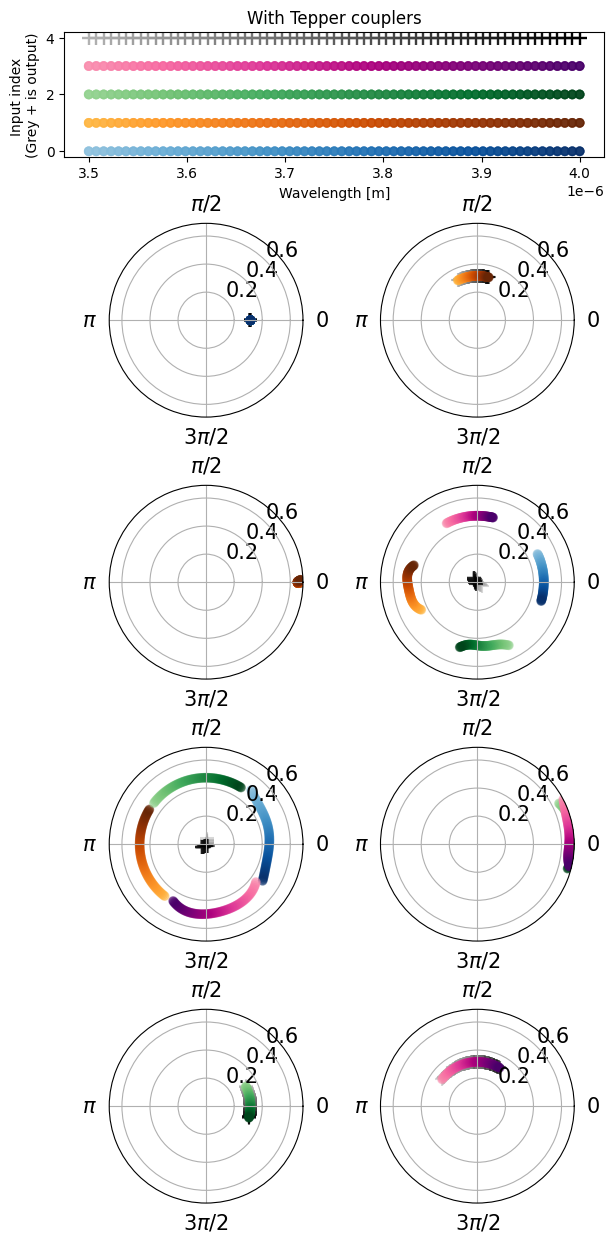

In [72]:
from kernuller.diagrams import plot_chromatic_matrix, plot_outputs_smart
# asim.combiner = sf.combiner.combiner.from_config(asim.config, ph_shifters=(0,-np.pi/2))
# asim.combiner.chromatic_matrix(asim.lambda_science_range)
# asim.point(asim.sequence[10], asim.target, refresh_array=True)

asim.point(asim.sequence[0], asim.target)
g_atmo = asim.offband_model.get_phase_science_values(asim.pistons)
g_internal = asim.corrector.get_phasor(asim.lambda_science_range)
# plt.plot(asim.lambda_science_range, g_atmo)
# plt.plot(asim.lambda_science_range, g_internal)
Mcnc = asim.combiner.Mcn*g_internal[:,None,:]

fig1, axs = plot_outputs_smart(matrix = asim.combiner.Mcn[30])
fig1.show()
fig2, axs, matrix = plot_chromatic_matrix(asim.combiner.M,
                                         sf.combiners.lamb, asim.lambda_science_range,
                                         verbose=False, returnmatrix=True,minfrac=0.9,
                                         plotout=True, show=False, title="With Tepper couplers")
fig2.show()
fig3, axs, matrix = plot_chromatic_matrix(asim.combiner.M,
                                         sf.combiners.lamb, asim.lambda_science_range,
                                         verbose=False, returnmatrix=True,minfrac=0.9,
                                         plotout=g_internal, show=False, title="With Tepper couplers")
fig3.show()

Using loc_array [[  0. 100.]
 [100.   0.]]


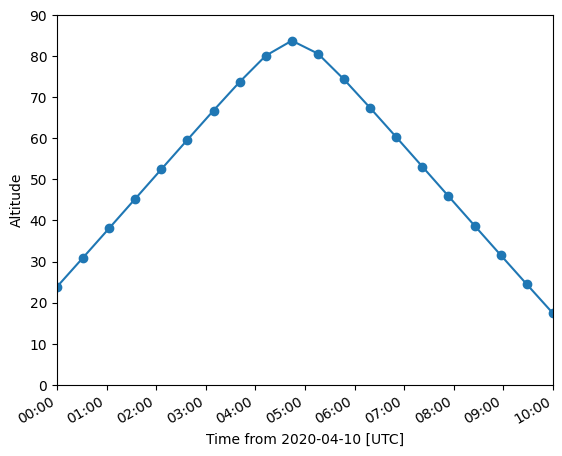

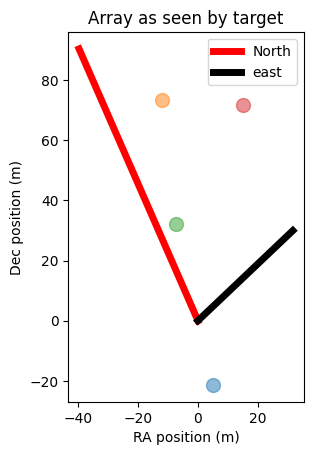

Using loc_array [[  0. 100.]
 [100.   0.]]


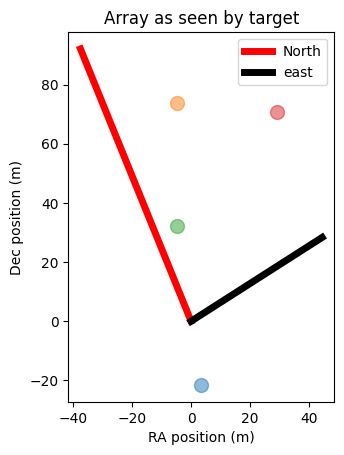

Using loc_array [[  0. 100.]
 [100.   0.]]


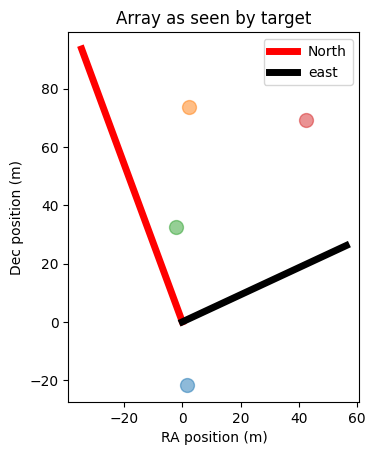

Using loc_array [[  0. 100.]
 [100.   0.]]


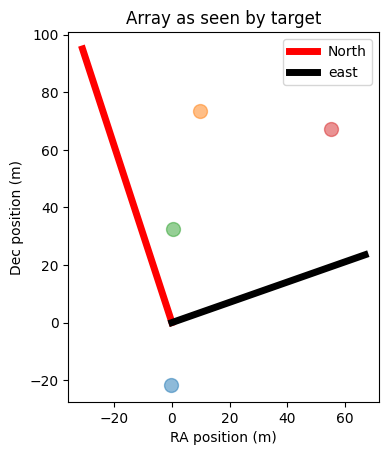

Using loc_array [[  0. 100.]
 [100.   0.]]


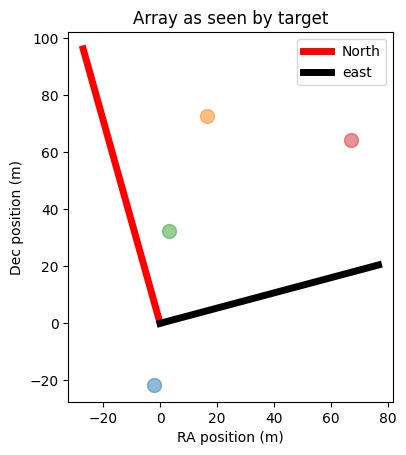

Using loc_array [[  0. 100.]
 [100.   0.]]


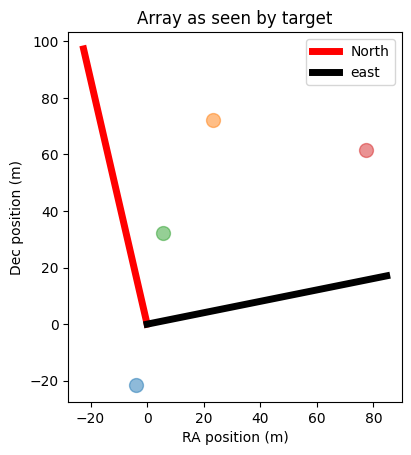

Using loc_array [[  0. 100.]
 [100.   0.]]


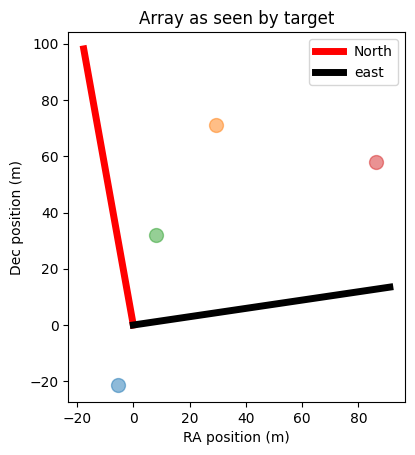

Using loc_array [[  0. 100.]
 [100.   0.]]


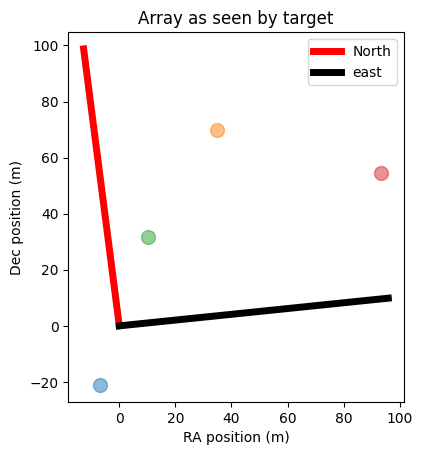

Using loc_array [[  0. 100.]
 [100.   0.]]


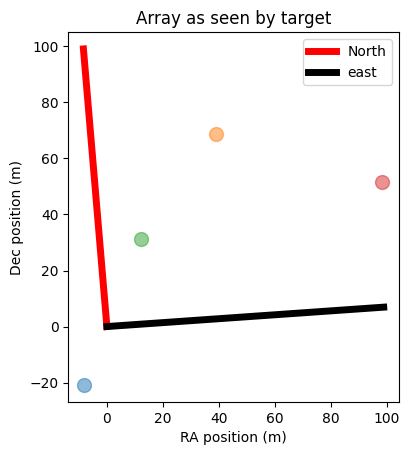

Using loc_array [[  0. 100.]
 [100.   0.]]


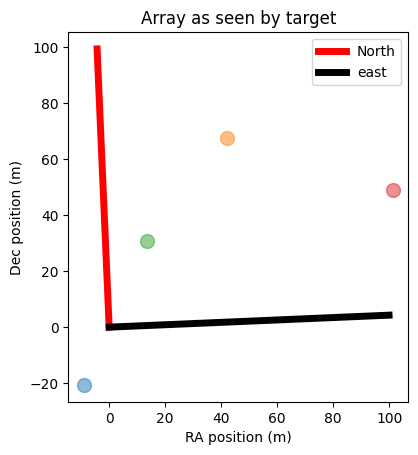

Using loc_array [[  0. 100.]
 [100.   0.]]


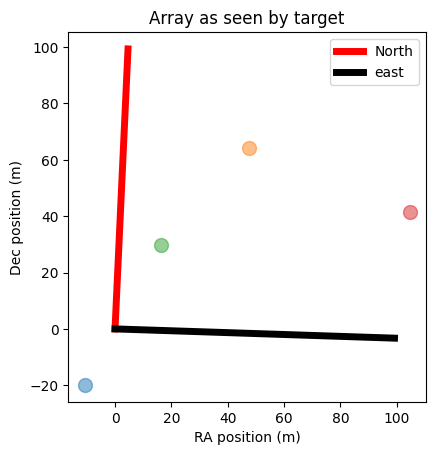

Using loc_array [[  0. 100.]
 [100.   0.]]


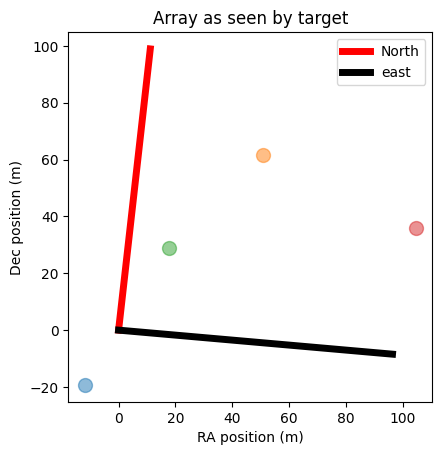

Using loc_array [[  0. 100.]
 [100.   0.]]


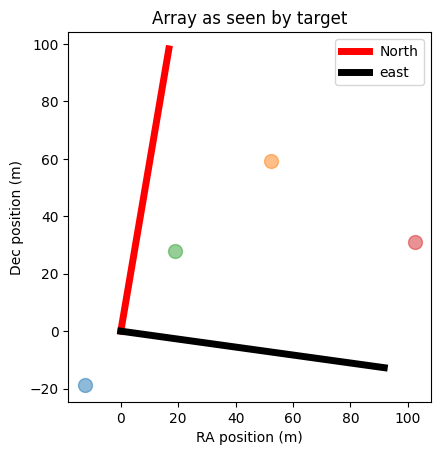

Using loc_array [[  0. 100.]
 [100.   0.]]


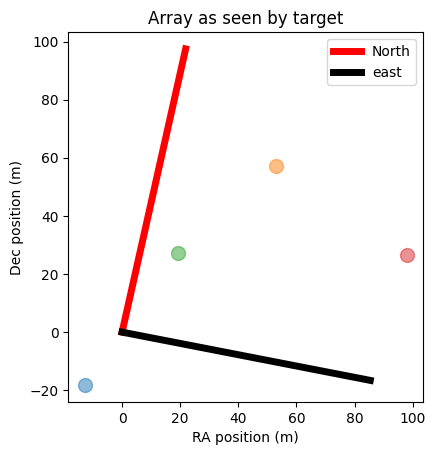

Using loc_array [[  0. 100.]
 [100.   0.]]


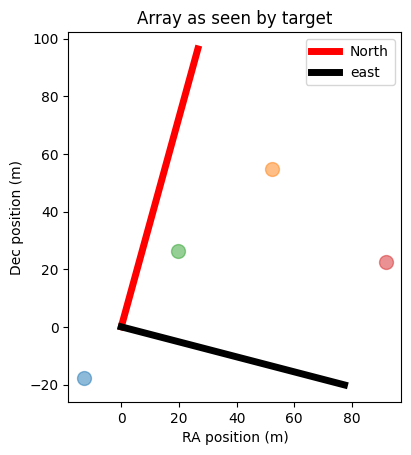

Using loc_array [[  0. 100.]
 [100.   0.]]


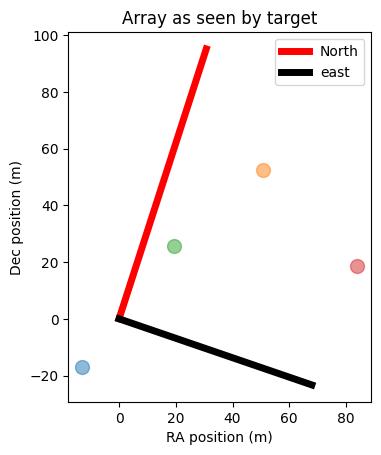

Using loc_array [[  0. 100.]
 [100.   0.]]


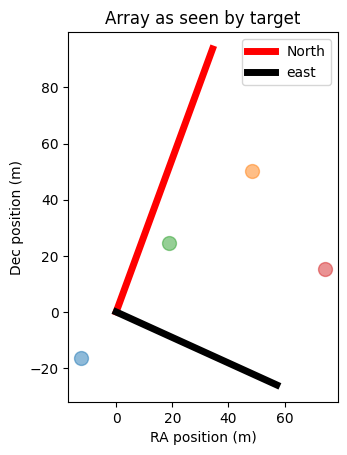

Using loc_array [[  0. 100.]
 [100.   0.]]


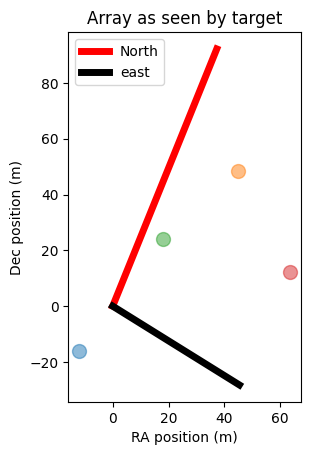

Using loc_array [[  0. 100.]
 [100.   0.]]


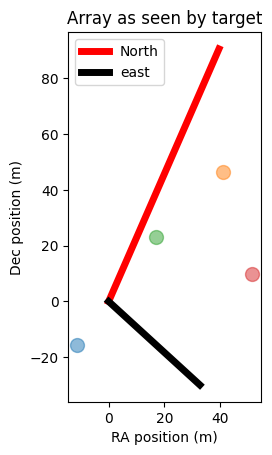

Using loc_array [[  0. 100.]
 [100.   0.]]


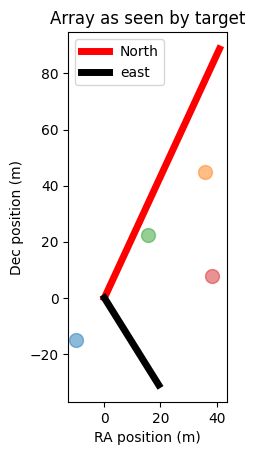

In [73]:
sf.observatory.plots.plot_altitude(asim.target, asim.obs.observatory_location, asim.sequence[:], )
for i in range(len(asim.sequence[:])):
    fig = sf.plot_tools.plot_projected_pupil(asim, i, perspective=False, usize=200)
# plt.sca(fig.axes[0])
# plt.xlim(-20, 20)
# plt.legend(fontsize=7)
# plt.show()

0.010601259160261856
(20, 67, 8, 16900)


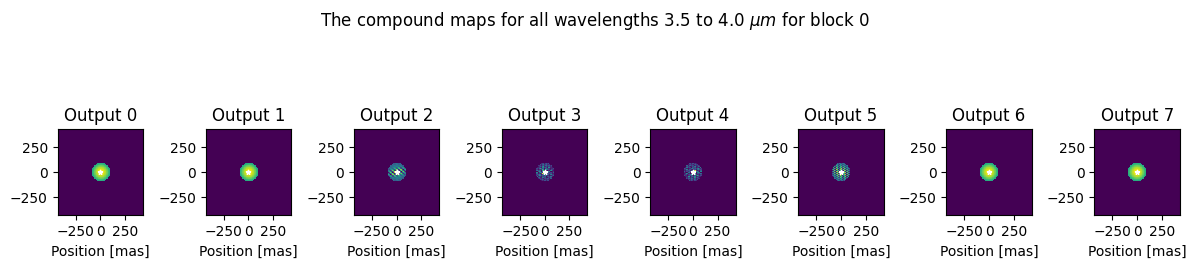

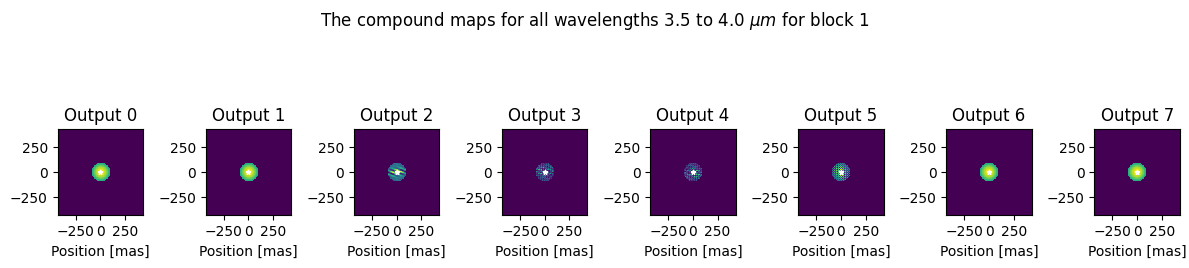

[<Figure size 1200x300 with 8 Axes>, <Figure size 1200x300 with 8 Axes>]

In [74]:
#asim.build_all_maps(mapres=100, mapcrop=0.06 )
asim.build_all_maps(mapres=130, mapcrop=0.6 )
sf.plot_tools.plot_response_map(asim, sequence_index=(0,1), )


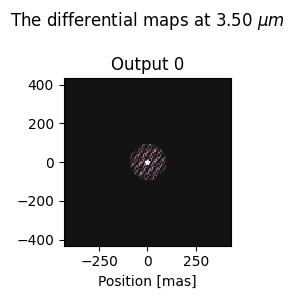

[<Figure size 1200x300 with 1 Axes>]

In [75]:
sf.plot_tools.plot_differential_map(asim, sequence_index=[10,], cmap=bo, wavelength=0, dpi=100)

In [76]:
t_exp = 1.0
# asim.combiner.chromatic_matrix(asim.lambda_science_range)
asim.point(asim.sequence[0], asim.target)

integ = asim.make_metrologic_exposure(asim.src.planet, asim.src.star, asim.diffuse,
                                      texp=t_exp)
integ.prepare_t_exp_base()
integ.consolidate_metrologic()

perfect_injection = np.ones((asim.lambda_science_range.shape[0], asim.ntelescopes))
dummy_collected = np.ones(asim.lambda_science_range.shape[0])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 117.10it/s]


<IPython.core.display.Math object>

(67, 8)


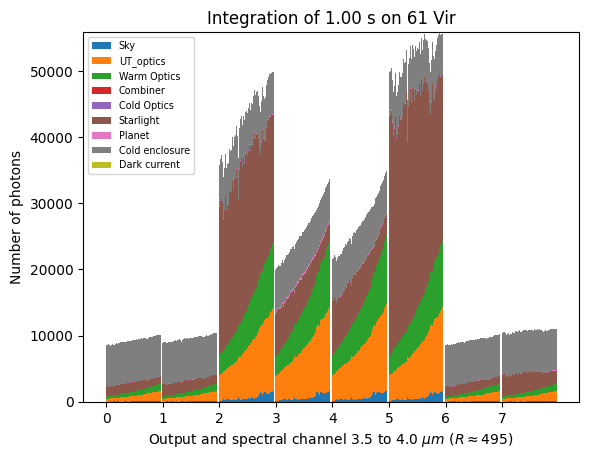

In [77]:
fig = sf.plot_tools.plot_output_sources(asim, integ, asim.lambda_science_range, t_exp=1)

# Skip the long series to evaluate covariance:

In [98]:
%%time
from tqdm import tqdm
exptime = 1.
if False:
    asim.point(asim.sequence[0], asim.target, )
    screen_age = 0.    
    aseq = []
    for i in tqdm(range(40)):
        for i in range(10):
            screen_age += exptime
            if screen_age>=20. :
                print("generating screen")
                asim.injector.update_screens()
                screen_age = 0.
            myint = asim.make_exposure(asim.src.planet, asim.src.star, asim.diffuse, texp=exptime)
            aseq.append(myint.get_total(n_pixsplit=8.0))
            myint.reset
        myint.reset
    aseq = np.array(aseq)
    akseq = np.einsum("k o, t w o -> t w k", asim.combiner.K, aseq)
    obs_mean = np.mean(aseq, axis=0)
    obs_std= np.std(aseq, axis=0)
    kobs_mean = np.mean(akseq, axis=0)
    kobs_std= np.std(akseq, axis=0)
    kobs_cov = np.cov(akseq.reshape(akseq.shape[0], -1).T)

CPU times: user 15 μs, sys: 96 μs, total: 111 μs
Wall time: 322 μs


## Instead load the covariance from an existing nifits file

You will have to figure out which shape is actually needed here: just one slice or the whole cube?

You can later recreate the error

NI_OSWAVELENGTH is for spectral oversampling
NI_DSAAMP is for spectral downsampling

In [110]:
# Extract the covariance matrix from another file. In reality, it should be recomputed for realstic simulations
myref_file = io.nifits.from_nifits(path + "nott_test_06_planet.nifits")
kobs_cov = myref_file.ni_kcov.kcov[0]*100  # 100 is the number of coadds used to create the covariance file

Missing OI_ARRAY
Missing NI_DSAMP
Missing NI_OSWAVELENGTH
Checking header True
contains_header: True


# Do the actual series

But simulate only one of the coadds, multiplying it by the bumber of coadds

**One more modification is missing: you have to get the values without the photon/read noise** Here it is automatically added by the metod `get_total` of the integrator object. There is certainly a way to get the full noiseless value, but I forgot.

You can then generate artificial errors quickly using the `np.random.normal` and pass a covariance matrix as the `scale` parameter. You can add that to the `KIout_means`. (nota: `Iout_mean` will be abnormally noiseless, though...)

The following box will plot the differential output spectrum. 

In [111]:
def get_total_noiseless(self, spectrograph=None, t_exp=None,
                 n_pixsplit=None):
        """
        Made a little bit complicated by the ability to simulate CRED1 camera. It is
        at this stage that the quantum efficiency ``self.eta`` is taken into account.
        
        **Parameters:**
        
        * spectrograph  : A spectrograph object to map the spectra on
          a 2D detector
        * t_exp         : [s]  Integration time to take into account dark current
          This is only used if self.exposure is close to 0. (if 
          the )
        * n_pixsplit    : The number of pixels over which to spread the
          signal of each spectral bin.
        """
        if n_pixsplit is not None: # Splitting the signal over a number pixels
            thepixels = self.acc.copy()
            thepixels = ((thepixels/n_pixsplit)[None,:,:]*np.ones(int(n_pixsplit))[:,None,None])
            #logit.warning("Usin post-defined n_pixsplit")
        else:
            thepixels = self.acc.copy()
            thepixels = ((thepixels/self.n_pixsplit)[None,:,:]*np.ones(self.n_pixsplit)[:,None,None])
        if np.isclose(self.exposure, 0., atol=1.e-8):
            self.exposure = t_exp
        obtained_dark = self.dark * self.exposure * self.mgain # This is done per pix
        obtained_cold_bg = self.cold_bg * self.exposure # This is done per pix
        if spectrograph is not None:
            acc = spectrograph.get_spectrum_image(thepixels)
        else:
            acc = thepixels
        electrons = acc * self.eta * self.mgain
        #set_trace()
        electrons = electrons + self.cold_bg[None,:,None] + obtained_dark
        expectancy = electrons.copy()
        electrons = np.random.poisson(lam=electrons*self.ENF)/self.ENF
        electrons = np.clip(electrons, 0, self.well)
        read = electrons
        if n_pixsplit is not None: # Binning the pixels again
            read = np.sum(read, axis=0)
        self.forensics = {"Expectancy": expectancy,
                         "Read noise": self.ron,
                         "Dark signal": obtained_dark}
        return read
sf.spectrograph.integrator.get_total_noiseless = get_total_noiseless

  0%|                                                                                                                            | 0/20 [00:00<?, ?it/s]

generating screen


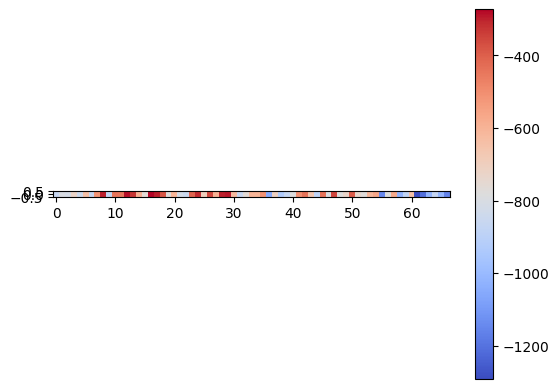

  5%|█████▊                                                                                                              | 1/20 [00:03<00:58,  3.07s/it]

generating screen


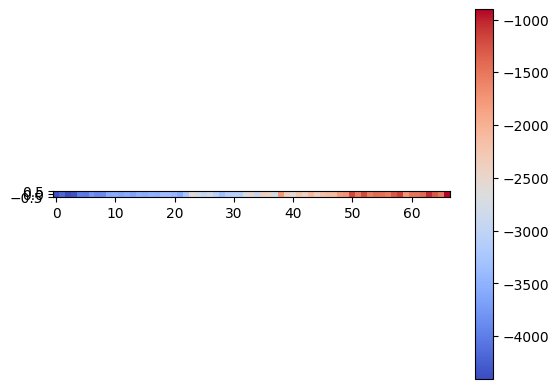

 10%|███████████▌                                                                                                        | 2/20 [00:07<01:06,  3.68s/it]

generating screen


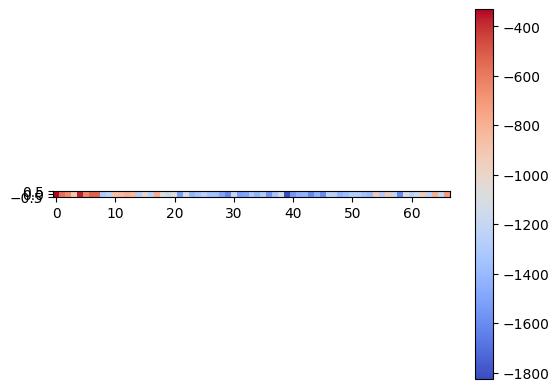

 15%|█████████████████▍                                                                                                  | 3/20 [00:10<00:58,  3.46s/it]

generating screen


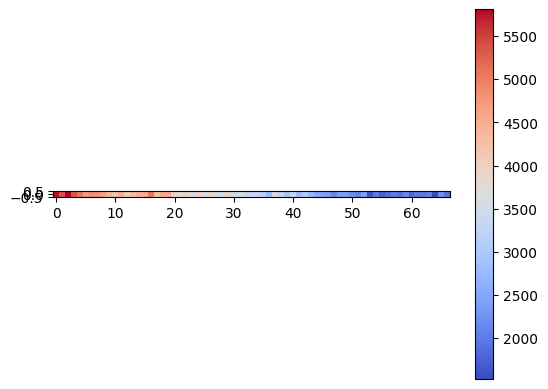

 20%|███████████████████████▏                                                                                            | 4/20 [00:13<00:55,  3.44s/it]

generating screen


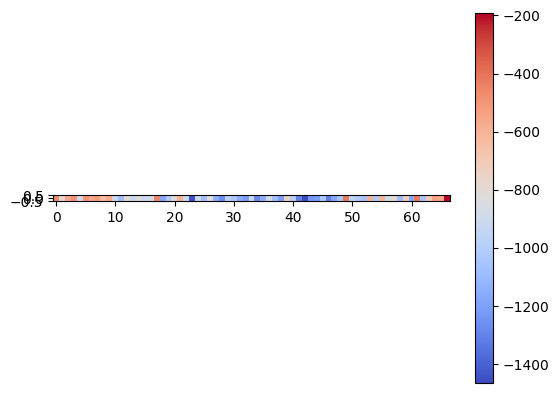

 25%|█████████████████████████████                                                                                       | 5/20 [00:17<00:50,  3.36s/it]

generating screen


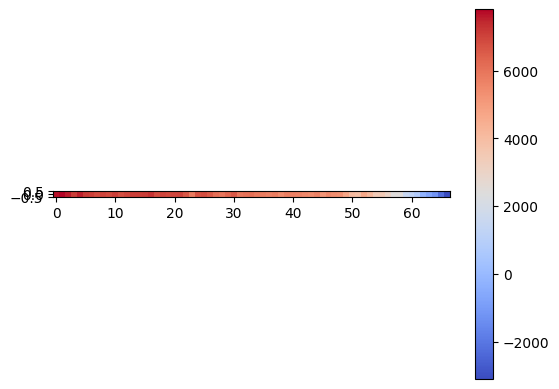

 30%|██████████████████████████████████▊                                                                                 | 6/20 [00:20<00:46,  3.32s/it]

generating screen


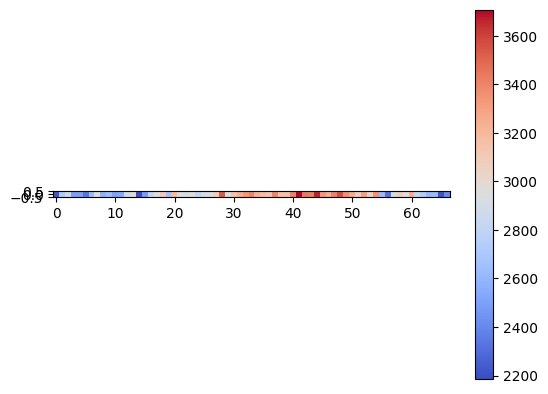

 35%|████████████████████████████████████████▌                                                                           | 7/20 [00:23<00:42,  3.27s/it]

generating screen


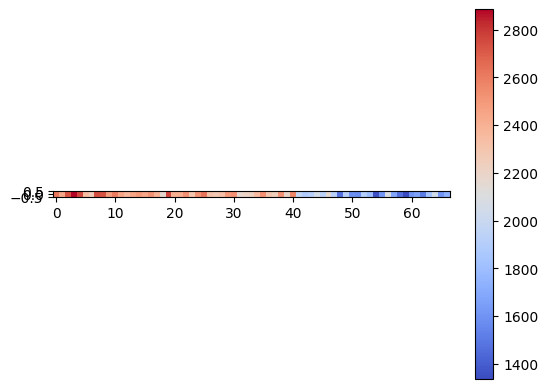

 40%|██████████████████████████████████████████████▍                                                                     | 8/20 [00:26<00:38,  3.22s/it]

generating screen


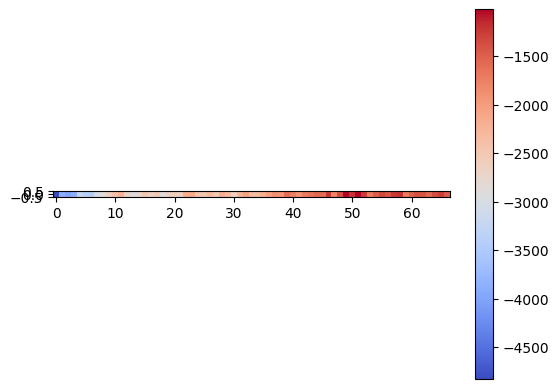

 45%|████████████████████████████████████████████████████▏                                                               | 9/20 [00:29<00:35,  3.20s/it]

generating screen


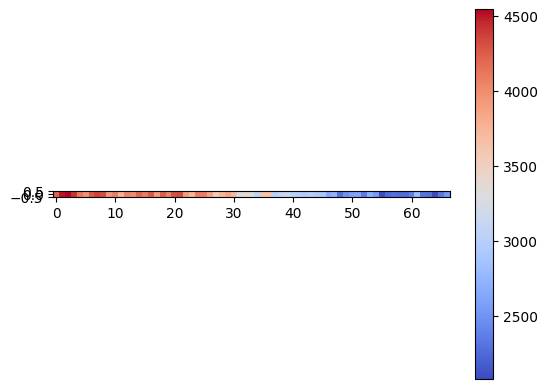

 50%|█████████████████████████████████████████████████████████▌                                                         | 10/20 [00:32<00:31,  3.18s/it]

generating screen


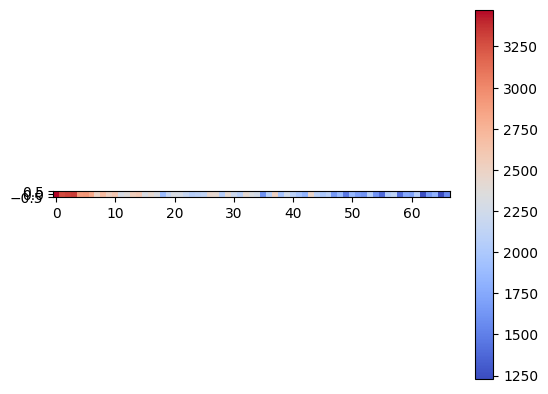

 55%|███████████████████████████████████████████████████████████████▎                                                   | 11/20 [00:35<00:28,  3.12s/it]

generating screen


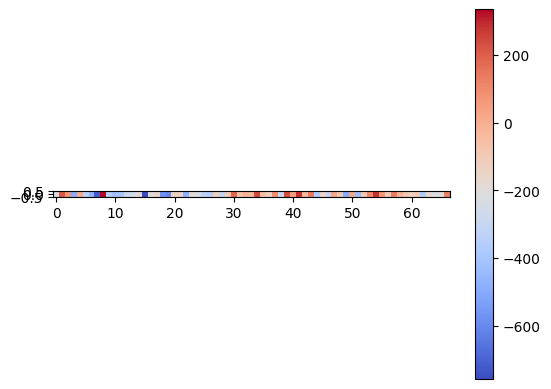

 60%|█████████████████████████████████████████████████████████████████████                                              | 12/20 [00:38<00:24,  3.07s/it]

generating screen


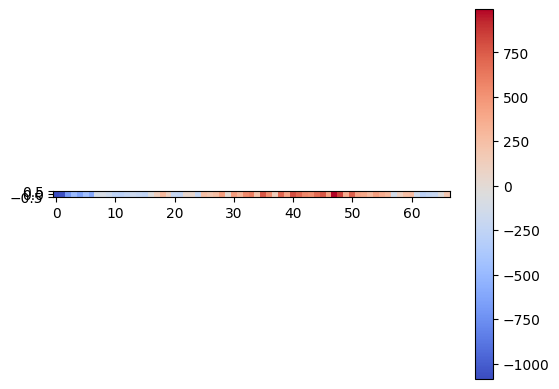

 65%|██████████████████████████████████████████████████████████████████████████▊                                        | 13/20 [00:41<00:21,  3.02s/it]

generating screen


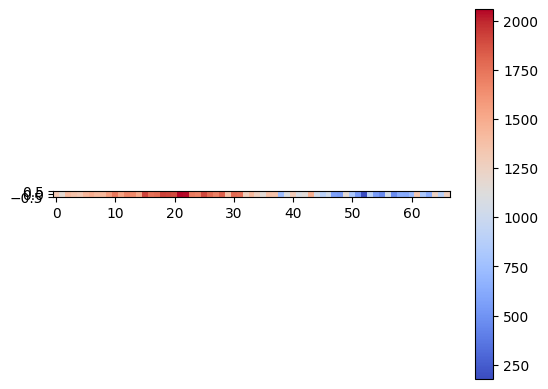

 70%|████████████████████████████████████████████████████████████████████████████████▌                                  | 14/20 [00:44<00:18,  3.02s/it]

generating screen


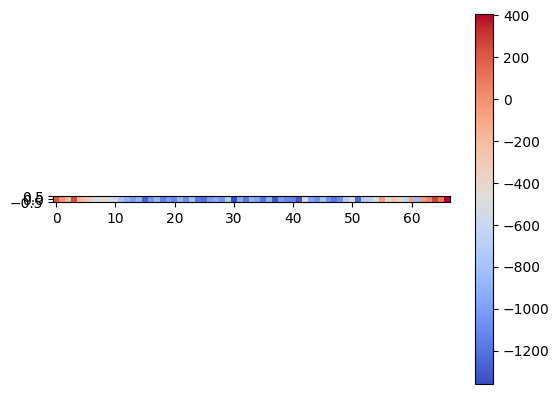

 75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 15/20 [00:47<00:15,  3.00s/it]

generating screen


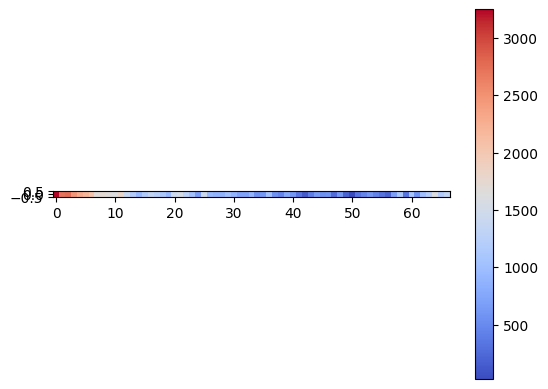

 80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 16/20 [00:50<00:11,  2.99s/it]

generating screen


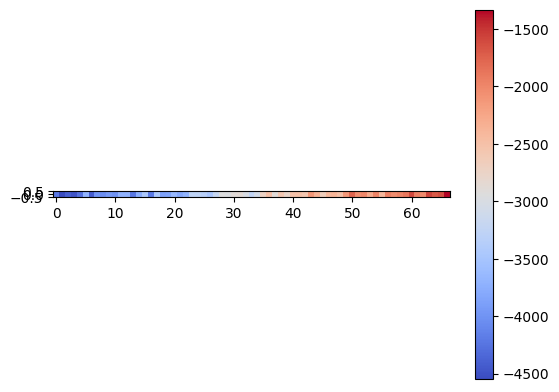

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 17/20 [00:53<00:09,  3.01s/it]

generating screen


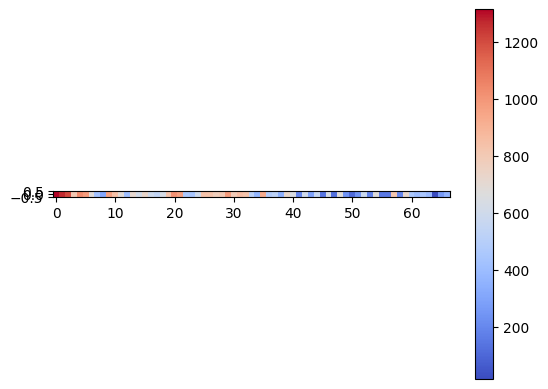

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 18/20 [00:56<00:05,  3.00s/it]

generating screen


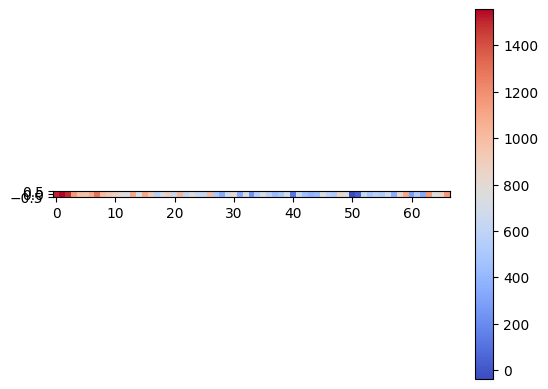

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 19/20 [00:59<00:02,  2.98s/it]

generating screen


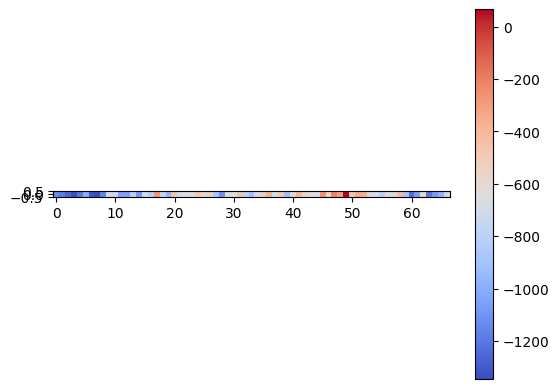

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:02<00:00,  3.13s/it]

CPU times: user 1min 6s, sys: 3.49 s, total: 1min 9s
Wall time: 1min 2s


In [112]:
%%time
n_coadds = 100
screen_age = 0
Iout_means = []
KIout_means = []
for i, atime in enumerate(tqdm(asim.sequence)):
    asim.point(atime, asim.target)
    print("generating screen")
    asim.injector.update_screens()
    bseq = []
    for i in range(1): ################################################## Do only one of the coadds
        screen_age += t_exp
        if screen_age>=20. :
            screen_age = 0.
        myint = asim.make_exposure(asim.src.planet, asim.src.star, asim.diffuse, texp=exptime)
        bseq.append(myint.get_total_noiseless(n_pixsplit=8.0))
        myint.reset()
    bseq = np.array(bseq)
    bkseq = np.einsum("k o, t w o -> t w k", asim.combiner.K, bseq)
    plt.figure()
    plt.imshow(bkseq, cmap="coolwarm")
    plt.colorbar()
    plt.show()
    obs_mean = np.mean(bseq, axis=0)
    kobs_mean = np.mean(bkseq, axis=0)
    Iout_means.append(obs_mean)
    KIout_means.append(kobs_mean)
Iout_means = np.array(Iout_means)
KIout_means = np.array(KIout_means)

    

In [113]:
import nifits.io.oifits as io
from astropy.table import Table, Column
def save_to_fits(self, Iout=None, KIout=None, Sigma=None, int_times_array=None):
    # def sim2nifits(self,)
    wl_data = np.hstack((self.lambda_science_range[:,None], np.gradient(self.lambda_science_range)[:,None]))
    wl_table = Table(data=wl_data, names=("EFF_WAVE", "EFF_BAND"), dtype=(float, float))
    del wl_data
    oi_wavelength = io.OI_WAVELENGTH(data_table=wl_table,)
    # oi_wavelength = io.OI_WAVELENGTH()
    ni_catm = io.NI_CATM(data_array=self.combiner.Mcn)
    
    mykmat = io.NI_KMAT(data_array=self.combiner.K)
    oi_target = io.OI_TARGET.from_scratch()
    oi_target.add_target(target=self.target.name, 
                          raep0=self.target.ra.deg, 
                          decep0=self.target.dec.deg)
    
    from copy import copy
    my_FOV_header = copy(io.NI_FOV_DEFAULT_HEADER)
    my_FOV_header["NIFITS FOV_TELDIAM"] = self.injector.pdiam
    my_FOV_header["NIFITS FOV_TELDIAM_UNIT"] = "m"
    ni_fov = io.NI_FOV.simple_from_header(header=my_FOV_header, lamb=self.lambda_science_range,
                                      n=len(self.sequence))
    overhead = 0.3
    n_telescopes = self.ntelescopes
    # dateobs = Time("2035-06-23T00:00:00.000") + times_relative*u.s
    dateobs = self.sequence
    mjds = dateobs.to_value("mjd")
    seconds = (dateobs - dateobs[0]).to_value("s")
    exptimes = np.gradient(seconds) * overhead
    target_id = np.zeros_like(seconds)
    app_index = np.arange(self.ntelescopes)[None,:]*np.ones(len(self.sequence))[:,None]
    target_ids = 0 * np.ones(len(self.sequence))
    if int_times_array is None:
        int_times_array = np.gradient(seconds)
    
    appxy = []
    mod_phas = []
    for atime in self.sequence:
        self.point(atime, self.target)
        g_atmo = self.offband_model.get_phase_science_values(self.pistons)
        g_internal = self.corrector.get_phasor(self.lambda_science_range)
        throughput = self.src.sky.get_downstream_transmission(self.lambda_science_range, )
        total_phasor = throughput[:,None] * np.exp(1j*g_atmo) * g_internal
        mod_phas.append(total_phasor)
        appxy.append(self.obs.get_projected_array())
        
    mod_phas = np.array(mod_phas)
    appxy = np.array(appxy)
    
    arrcol = np.ones((len(self.sequence), self.ntelescopes)) * self.injector.collecting
    fov_index = np.ones(len(self.sequence))
    
    app_index         = Column(data=app_index, name="APP_INDEX",
                       unit=None, dtype=int)
    target_id         = Column(data=target_ids, name="TARGET_ID",
                       unit=None, dtype=int)
    times_relative    = Column(data=seconds, name="TIME",
                       unit="", dtype=float)
    mjds              = Column(data=mjds, name="MJD",
                       unit="day", dtype=float)
    int_times         = Column(data=int_times_array, name="INT_TIME",
                       unit="s", dtype=float)
    mod_phas          = Column(data=mod_phas, name="MOD_PHAS",
                       unit="rad", dtype=complex)
    appxy             = Column(data=appxy, name="APPXY",
                       unit="m", dtype=float)
    arrcol            = Column(data=arrcol, name="ARRCOL",
                       unit="m^2", dtype=float)
    fov_index         = Column(data=fov_index, name="FOV_INDEX",
                       unit=None, dtype=int)
    mymod_table = Table()
    mymod_table.add_columns((app_index, target_id, times_relative, mjds,
                            int_times, mod_phas, appxy, arrcol, fov_index))
    mymod_table
    mynimod = io.NI_MOD(mymod_table)

    outbright = data=asim.combiner.bright[None,:]
    outphot = asim.combiner.photometric[None,:]
    outdark = asim.combiner.dark[None,:]
    ni_iotags = io.NI_IOTAGS.from_arrays(outbright=outbright, outdark=outdark, outphot=outphot,
                             inpola = inpol, outpola=outpol)
    
    myheader = io.fits.Header()

    if Iout is not None:
        Iout_table = Table(data=(Iout,), names=("value",), dtype=(float,), )
        myiout = io.NI_IOUT(data_table=Iout_table, unit=(units.ph/units.s))
        # myiout.name="NI_IOUT"
    if KIout is not None:
        KIout_table = Table(data=(KIout,), names=("value",), dtype=(float,), )
        mykiout = io.NI_KIOUT(data_table=KIout_table, unit=(units.ph/units.s))
        # mykiout.name="NI_KIOUT"
    if Sigma is not None:
        kcov_header = io.fits.Header()
        kcov_header["SHAPE"] = ("frame (wavelength output)", "The shape of the covariance array.")
        mykcov = io.NI_KCOV(data_array=Sigma, header=kcov_header, unit=(units.ph/units.s)**2)
        mykcov.name = "NI_KCOV"
    mynifit = io.nifits(header=myheader,
                        ni_catm=ni_catm,
                        ni_fov=ni_fov,
                        oi_target=oi_target,
                        oi_wavelength=oi_wavelength,
                        ni_mod=mynimod,
                        ni_iout=myiout,
                        ni_kiout=mykiout,
                        ni_kcov=mykcov,
                        ni_kmat=mykmat,
                        ni_iotags=ni_iotags)
    return mynifit

In [114]:
mykcov = 1/n_coadds * np.ones(len(asim.sequence))[:,None,None] * kobs_cov[None,:,:]
anifits = save_to_fits(asim, Iout=Iout_means/exptime, KIout=KIout_means, Sigma=mykcov,
                       int_times_array=np.ones(len(asim.sequence)) * exptime * n_coadds)
myhdul = anifits.to_nifits("dummy_name", overwrite=False, writefile=False)
myhdul["PRIMARY"].header.append(("SCIFYSIM DISTANCE", asim.src.distance, "[pc] Distance to target"))
myhdul["PRIMARY"].header.append(("SCIFYSIM R_STAR", asim.src.star.radius, "[R_sun] Radius of star"))
myhdul["PRIMARY"].header.append(("SCIFYSIM T_STAR", asim.src.star.T, "[K] Temperature of star"))
myhdul["PRIMARY"].header.append(("SCIFYSIM R_PLANET", asim.src.planet.radius, "[R_sun] Radius of star"))
myhdul["PRIMARY"].header.append(("SCIFYSIM T_PLANET", asim.src.planet.T, "[K] Temperature of planet"))
myhdul["PRIMARY"].header.append(("SCIFYSIM SEP", asim.src.planet_separation, "[mas] Separation of planet"))
myhdul["PRIMARY"].header.append(("SCIFYSIM PA", asim.src.planet_position_angle, "[deg] Position angle (east of north) possible error"))
myhdul["PRIMARY"].header.append(("SCIFYSIM TARNAME", asim.target.name , ""))
myhdul.writeto(f"{output_file}", overwrite=True)


OI_ARRAY True
oi_array
OI_WAVELENGTH True
oi_wavelength
NI_CATM True
ni_catm
Updating header:
NI_FOV True
ni_fov
NI_KMAT True
ni_kmat
Updating header:
NI_MOD True
ni_mod
NI_IOUT True
ni_iout
WARNING-astroquery- VerifyWarning: Keyword name 'NIFITS IUNIT' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
NI_KIOUT True
ni_kiout
NI_KCOV True
ni_kcov
Updating header:
NI_DSAMP True
ni_dsamp
NI_OSWAVELENGTH True
ni_oswavelength
NI_IOTAGS True
ni_iotags
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  HIERARCH NIFITS OI_ARRAY = 'Not included (None)'                                HIERARCH NIFITS OI_WAVELENGTH = 'Included'                                      H

In [115]:
from nifits.backend import backend
def plot_barcode(self, outindex, diffout=False, cmap=None, **kwargs):
    import matplotlib.pyplot as plt
    if cmap is None:
        if diffout:
            cmap = "coolwarm"
        else:
            cmap = "viridis"
    xs = self.nifits.ni_mod.data_table["MJD"]
    if not diffout:
        for i, awl in enumerate(self.nifits.oi_wavelength.lambs):
            plt.scatter(xs, awl*np.ones_like(xs), c=self.nifits.ni_iout.iout[:,i,outindex],
                        marker="s", cmap=cmap, **kwargs)
    else:
        
        cmax = np.nanmax(np.abs(self.nifits.ni_kiout.kiout[:,:,outindex]))
        cmin = -cmax
        for i, awl in enumerate(self.nifits.oi_wavelength.lambs):
            plt.scatter(xs, awl*np.ones_like(xs), c=self.nifits.ni_kiout.kiout[:,i,outindex],
                   marker="s", vmin=cmin, vmax=cmax, cmap=cmap, **kwargs)
    plt.xlabel("MJD [d]")
    plt.ylabel("Wavelength [m]")
    plt.gca().set_aspect("auto")
    plt.title(f"Output {outindex} [{self.nifits.ni_iout.unit}]")
    plt.colorbar()
backend.NI_Backend.plot_barcode = plot_barcode

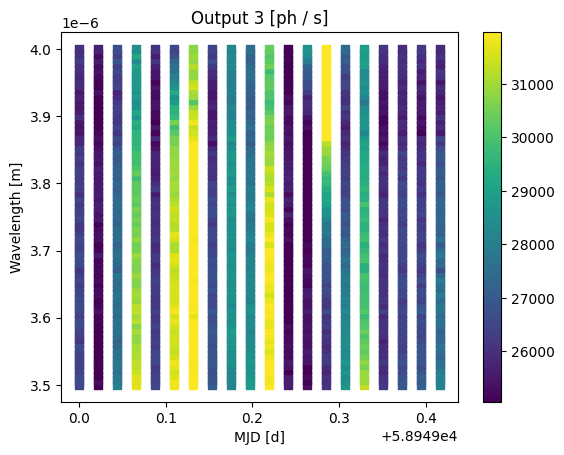

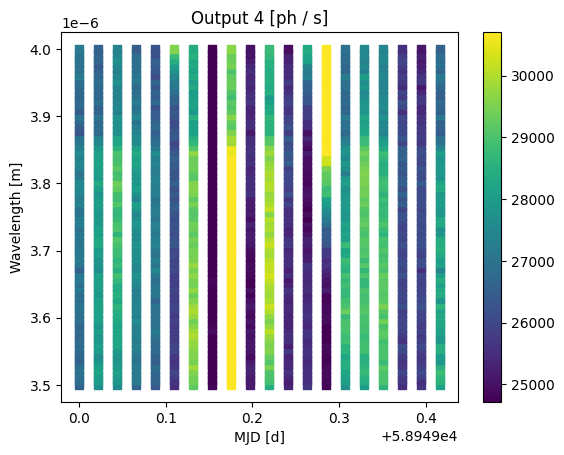

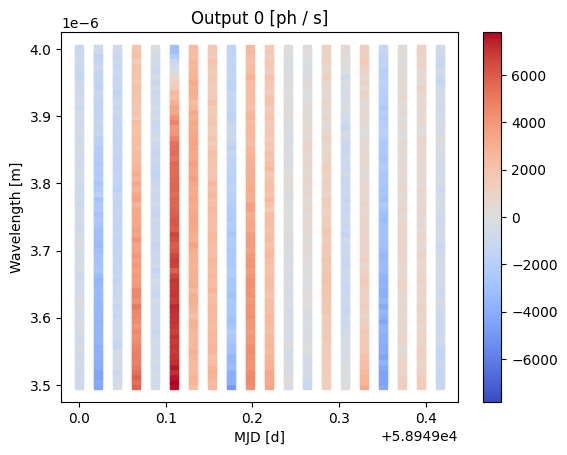

In [116]:
abe = backend.NI_Backend(anifits)
plt.figure()
abe.plot_barcode(3)
plt.show()
plt.figure()
abe.plot_barcode(4)
plt.show()
plt.figure()
abe.plot_barcode(0, diffout=True, cmap="coolwarm")
plt.show()

In [117]:
kappa_inv = np.array([abe.nifits.ni_catm.M[i,abe.nifits.ni_iotags.outphot[0],:] for i in range(abe.nifits.oi_wavelength.lambs.shape[0])])
kappa_inv

array([[[ 0.31622777+0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        , -0.03540628+0.31423939j,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.31622777+0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        , -0.03540628+0.31423939j]],

       [[ 0.31622777+0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        , -0.03426379+0.31436602j,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.31622777+0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        , -0.03426379+0.31436602j]],

       [[ 0.31622777+0.j        ,  0.       

In [151]:
# Look at detection limits of the simulated file

# Import extra and backend
import nifits.backend as be 
import nifits.extra as ex 

# Open the nifits file as backend
data = io.nifits.from_nifits(output_file) # Import file
myex = ex.Post(data)                      # Create extra backend 
myex.create_fov_function_all()            # Create field-of-view based on the NIFITS

# Create whitening matrix
wm = myex.create_whitening_matrix(replace=False)

# Create a point collection for one position in the fov and coordinates
one_point = be.PointCollection(np.array((0.,)), np.array((60.,)), unit=units.mas)

# Get expected sensitivity based on the simulated observations
dpc = myex.nifits.header['HIERARCH SCIFYSIM DISTANCE']
tst = myex.nifits.header['HIERARCH SCIFYSIM T_STAR']
sep = myex.nifits.header['HIERARCH SCIFYSIM SEP']
pa  = myex.nifits.header['HIERARCH SCIFYSIM PA']
tpl = myex.nifits.header['HIERARCH SCIFYSIM T_PLANET']
sm  = myex.get_sensitivity_te(*one_point.coords_rad, kernels=True, temperature=tpl*units.K, pfa=0.046, pdet=0.90, distance=dpc*units.pc, radius_unit=u.Rjup, md=np)

# Now create simulated outputs for model fitting
zd = myex.get_all_outs(*one_point.coords_rad, kernels=False) # Create transmission map at position "one_point" for all outputs and frames
zt = myex.get_all_outs(*one_point.coords_rad, kernels=True)  # Create differential nulling output at position "one_point" for all outputs and frames

# print stuff
print(f"-------------")
print(f"INPUTS")
print(f"- Stellar name: {target}")
print(f"- Target distance: {dpc} pc")
print(f"- Target temperature: {tst} K")
print(f"- Expected planet temperature: {tpl} K")
print(f"- Expected planet position (sep, pa): {sep} mas, {pa} deg")
print(f"-------------")
print(f"OUTPUTS")
print(f"- NOTT detection limit at position in Jupiter radius: {sm}")


Missing OI_ARRAY
Missing NI_DSAMP
Missing NI_OSWAVELENGTH
Checking header True
contains_header: True
erg ph / (J s sr cm2)
Ref spectrum unit:  1 / rad2
Ref signal (x) unit:  1 / rad2
Ref signal (x) shape:  (1340, 1)
-------------
INPUTS
- Stellar name: 61 Vir
- Target distance: 8.51 pc
- Target temperature: 5915.33 K
- Expected planet temperature: 1000.0 K
- Expected planet position (sep, pa): 60.0 mas, 90.0 deg
-------------
OUTPUTS
- NOTT detection limit at position in Jupiter radius: [4.56741548] jupiterRad


In [43]:
# Create a simuated model

# Open the nifits file as backend
nifits = io.nifits.from_nifits(output_file) # Import file
mybe   = be.NI_Backend(nifits)              # Create backend for forward model
mybe.create_fov_function_all()              # Create field-of-view based on the NIFITS

# Create a point collection for one position in the fov
one_point = be.PointCollection(np.array((0.,)), np.array((60.,)), unit=units.mas)
zd = mybe.get_all_outs(*one_point.coords_rad, kernels=False) # Create transmission map at position "one_point" for all outputs and frames
zt = mybe.get_all_outs(*one_point.coords_rad, kernels=True)  # Create differential nulling output at position "one_point" for all outputs and frames

# Compare with 
mybe.nifits.iout.data_array # data_array or data_table
mybe.nifits.kiout.data_array


Missing OI_ARRAY
Missing NI_DSAMP
Missing NI_OSWAVELENGTH
Checking header True
contains_header: True


AttributeError: 'nifits' object has no attribute 'iout'

from astropy.table import Table, Column
from astropy.time import Time
from astropy import units

import nifits.io.oifits as io

# def sim2nifits(self,)
wl_data = np.hstack((asim.lambda_science_range[:,None], np.gradient(asim.lambda_science_range)[:,None]))
wl_table = Table(data=wl_data, names=("EFF_WAVE", "EFF_BAND"), dtype=(float, float))
del wl_data
oi_wavelength = io.OI_WAVELENGTH(data_table=wl_table,)
# oi_wavelength = io.OI_WAVELENGTH()

ni_catm = io.NI_CATM(data_array=asim.combiner.Mcn)

mykmat = io.NI_KMAT(data_array=asim.combiner.K)
oi_target = io.OI_TARGET.from_scratch()
oi_target.add_target(target=asim.target.name, 
                      raep0=asim.target.ra.deg, 
                      decep0=asim.target.dec.deg)


from copy import copy
my_FOV_header = copy(io.NI_FOV_DEFAULT_HEADER)
my_FOV_header["FOV_TELDIAM"] = asim.injector.pdiam
my_FOV_header["FOV_TELDIAM_UNIT"] = "m"
ni_fov = io.NI_FOV.simple_from_header(header=my_FOV_header, lamb=asim.lambda_science_range,
                                  n=len(asim.sequence))
overhead = 0.3
n_telescopes = asim.ntelescopes
# dateobs = Time("2035-06-23T00:00:00.000") + times_relative*u.s
dateobs = asim.sequence
mjds = dateobs.to_value("mjd")
seconds = (dateobs - dateobs[0]).to_value("s")
exptimes = np.gradient(seconds) * overhead
target_id = np.zeros_like(seconds)
app_index = np.arange(asim.ntelescopes)[None,:]*np.ones(len(asim.sequence))[:,None]
target_ids = 0 * np.ones(len(asim.sequence))
int_times = np.gradient(seconds)

appxy = []
mod_phas = []
for atime in asim.sequence:
    asim.point(atime, asim.target)
    g_atmo = asim.offband_model.get_phase_science_values(asim.pistons)
    g_internal = asim.corrector.get_phasor(asim.lambda_science_range)
    throughput = asim.src.sky.get_downstream_transmission(asim.lambda_science_range, )
    total_phasor = throughput[:,None] * np.exp(1j*g_atmo) * g_internal
    mod_phas.append(total_phasor)
    appxy.append(asim.obs.get_projected_array())
    
mod_phas = np.array(mod_phas)
appxy = np.array(appxys)

arrcol = np.ones((len(asim.sequence), asim.ntelescopes)) * asim.injector.collecting
fov_index = np.ones(len(asim.sequence))

app_index         = Column(data=app_index, name="APP_INDEX",
                   unit=None, dtype=int)
target_id         = Column(data=target_ids, name="TARGET_ID",
                   unit=None, dtype=int)
times_relative    = Column(data=seconds, name="TIME",
                   unit="", dtype=float)
mjds              = Column(data=mjds, name="MJD",
                   unit="day", dtype=float)
int_times         = Column(data=seconds, name="INT_TIME",
                   unit="s", dtype=float)
mod_phas          = Column(data=mod_phas, name="MOD_PHAS",
                   unit="rad", dtype=complex)
appxy             = Column(data=appxy, name="APPXY",
                   unit="m", dtype=float)
arrcol            = Column(data=arrcol, name="ARRCOL",
                   unit="m^2", dtype=float)
fov_index         = Column(data=fov_index, name="FOV_INDEX",
                   unit=None, dtype=int)
mymod_table = Table()
mymod_table.add_columns((app_index, target_id, times_relative, mjds,
                        int_times, mod_phas, appxy, arrcol, fov_index))
mymod_table
mynimod = io.NI_MOD(mymod_table)


myheader = io.fits.Header()
mynifit = io.nifits(header=myheader,
                        ni_catm=ni_catm,
                        ni_fov=ni_fov,
                        oi_target=oi_target,
                        oi_wavelength=oi_wavelength,
                        ni_mod=mynimod,
                        ni_kmat=mykmat)
mynifit.__dict__.keys()
mynifit.to_nifits(filename="test_nifits.nifits", overwrite=True)


In [26]:
import numpy as np
import nifits
import nifits.io.oifits as io
import nifits.backend as be

import matplotlib.pyplot as plt

new_nifits = io.nifits.from_nifits("nott_test_06_planet_3Rj.nifits")
abe = be.NI_Backend(new_nifits)
abe.create_fov_function_all()

FileNotFoundError: [Errno 2] No such file or directory: 'nott_test_06_planet_3Rj.nifits'

In [ ]:
%%time
acollec = be.PointCollection.from_uniform_disk(150., 10000,)
z = abe.get_all_outs(*acollec.coords_rad, kernels=True)

In [ ]:
plt.figure(dpi=200)
plt.scatter(*acollec.coords, c=z[0,-1,0,:], cmap="coolwarm", s=2)
plt.colorbar()
plt.show()

x_inj = abe.nifits.ni_fov.xy2phasor(*acollec.coords_rad)
plt.figure()
plt.scatter(*acollec.coords, c=np.abs(x_inj[0,-1,:]), cmap="viridis", s=1)
plt.colorbar()
plt.show()
print(np.max(z))


In [ ]:
new_nifits.ni_kiout.data_table

In [ ]:
plt.figure()
plt.imshow(new_nifits.ni_kcov.data_array[0] )
plt.colorbar()
plt.figure()
plt.imshow(new_nifits.ni_iout.data_table["value"][:,:,3])
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(new_nifits.ni_iout.data_table["value"][:,:,4])
plt.colorbar()
plt.show()

plt.figure()
for i, anout in enumerate(new_nifits.ni_iout.data_table["value"][:,:,4]):
    plt.plot(new_nifits.oi_wavelength.lambs, anout, label=str(i))
plt.legend(fontsize=7)
plt.show()

plt.figure()
for i, anout in enumerate(new_nifits.ni_kiout.data_table["value"][:,:,0]):
    plt.plot(new_nifits.oi_wavelength.lambs, anout, label=str(i))
plt.legend(fontsize=7)
plt.show()

In [ ]:
%%time
acollec = be.PointCollection.from_uniform_disk(25., 1000, md=np)
z = abe.get_all_outs(*acollec.coords_rad, kernels=True)

from einops import rearrange
rez = rearrange(z, "times wl out point ->  point (times wl out)")
rek = rearrange(abe.nifits.ni_kiout.kiout, "times wl out -> (times wl out)")

correl = rez.dot(rek)/np.linalg.norm(rez, axis=1)
id_max = np.argmax(correl)
cps = 20.*np.exp(1j*(np.pi/2 - np.deg2rad(60.)))

plt.figure()
plt.scatter(*acollec.coords, c=correl, s=50)
plt.gca().set_aspect("equal")
plt.colorbar()
plt.scatter(cps.real, cps.imag, color="k", marker="+", label="Ground truth")
plt.scatter(acollec.coords[0][id_max], acollec.coords[1][id_max], color="r", marker="+", label="Highest correlation")
plt.legend(fontsize=7)
plt.xlabel("Relative position [mas]")
plt.show()

In [ ]:

plt.figure()
for i in range(z.shape[-1]):
    plt.plot(np.sum(1000000*z[:, :, 0,i], axis=1))
plt.plot(np.sum(abe.nifits.ni_kiout.kiout[:,:,0], axis=1), color="k")
plt.plot(np.sum(1000000*z[:, :, 0, id_max], axis=1), color="k", linestyle="--")
plt.show()

In [ ]:

offset = 0.5
plt.figure()
plt.scatter(*acollec.coords, c=z[0,-1,0,:], cmap="coolwarm", s=40)
plt.colorbar()
for i, (ax, ay) in enumerate(zip(*acollec.coords)):
    # print(i, ax,ay)
    plt.text(ax+offset, ay+offset, s=str(i), fontsize=4)
plt.show()

x_inj = abe.nifits.ni_fov.xy2phasor(*acollec.coords_rad)
plt.figure()
plt.scatter(*acollec.coords, c=np.abs(x_inj[0,-1,:]), cmap="viridis", s=40)
plt.colorbar()
plt.show()
print(np.max(z))


from astropy.table import Table
class nott_nifits(object):
    def __init__(self, asim):
        self.missing = [] # To contain missing elements for TODO list

        # The OI_WAVELENGTH
        self.OI_WAVELENGTH_EFF_WAVE = asim.lambda_science_range
        self.OI_WAVELENGTH_EFF_BAND = np.gradient(self.OI_WAVELENGTH_EFF_WAVE)
        
        # The OI_ARRAY
        if isinstance(asim.obs, sf.observatory.observatory):
            self.OI_ARRAY_frame = "geocentric"
            self.OI_ARRAY_location = asim.obs.observatory_location
        elif isinstance(asim.obs, sf.observatory.ObservatoryAltAz):
            self.OI_ARRAY_frame = "altaz"
            self.OI_ARRAY_location = asim.obs.observatory_location
        elif isinstance(asim.obs, sf.observatory.SpaceObservatory):
            self.OI_ARRAY_frame = "None"
            self.missing.append("Observatory location for space")
        
        self.OI_ARRAY = asim.obs.statlocs
        self.OI_ARRAY_name = asim.config.get("configuration", "config")
        array_table = Table(names=["TEL_NAME", "STA_NAME", "STA_INDEX", "DIAMETER", "STAXYZ", "FOV", "FOVTYPE"],
              dtype=[str, str, int, float, np.ndarray, float, str])
        for i in np.arange(asim.obs.statlocs.shape[0]):
            print(f"Telescope{i}")
            anxy = asim.obs.statlocs[i]
            if asim.obs.statlocs[i].shape[0] == 2:
                anxyz = np.append(anxy, np.zeros(1), axis=0)
            else:
                anxyz = asim.obs.statlocs[i]
            fov = asim.lambda_science_range.mean()/asim.obs.pdiams[i]*units.rad.to(units.mas)
            array_table.add_row(vals=[f"Tel{i}", f"Sta{i}", i, asim.obs.pdiams[i], anxyz , fov, "RADIUS"])
        self.OI_ARRAY_table = array_table
        
        # self.array = asim.obs.get_projected_array()
        self.g_atmo = asim.offband_model.get_phase_science_values(asim.pistons)
        self.g_internal = asim.corrector.get_phasor(asim.lambda_science_range)
        self.Mcn = asim.combiner.Mcn*self.g_internal[:,None,:]
        self.missing.append("PERFECT INJECTION")
        self.throughput = asim.src.sky.get_downstream_transmission(asim.lambda_science_range, )
        self.NI_MOD = self.throughput[:,None] * np.exp(1j*self.g_atmo)

        # The NI_CATM
        self.NI_CATM = self.Mcn

        # The NI_KMAT
        self.NI_KMAT = asim.combiner.K
        
    def add_ni_mod(self, asim, target_id=1, int_time=1.):
        if not hasattr(self, "NI_MOD_table"):
            self.NI_MOD_table = Table (names=["TARGET_ID", "TIME", "MJD", "INT_TIME","MOD_PHAS" , "APPXY", "ARRCOL"],
                                    units=[None, units.s, units.day, units.s, None , units.m, units.m**2],
                                     dtype=[int, float, float, float, np.ndarray,  np.ndarray, float])
        xys = asim.obs.get_projected_array()
        allmods = self.throughput[:,None] * np.exp(1j*self.g_atmo)
        for i in np.arange(xys.shape[0]):
            self.NI_MOD_table.add_row([target_id, asim.obs.time.to_value("unix"), asim.obs.time.to_value("mjd"),
                                         int_time, allmods[:,i], xys[i], asim.injector.collecting])
            
    def add_ni_out(self, asim, ni_out=None, ni_mod=None, ni_vout=None,
                      target_id=1, int_time=1.):
        # General keywords:
        asim.DATE_OBS = asim.obs.time.isot

        # self.NI_MOD = asim.obs.get_projected_array()
        self.add_ni_mod(asim, target_id=target_id, int_time=int_time)
        
        # The NI_MOD
        if ni_mod is None:
            self.NI_MOD = ni_mod
        else:
            self.g_atmo = asim.offband_model.get_phase_science_values(asim.pistons)
            self.throughput = asim.src.sky.get_downstream_transmission(asim.lambda_science_range, )
            self.NI_MOD = self.throughput[:,None] * np.exp(1j*self.g_atmo)
            
        # The NI_OUT (main data)
        self.NI_OUT = ni_out
        self.NI_VOUT = ni_vout

    def add_ni_k(self, asim, ni_kout=None, ni_kcov=None):
        self.NI_KOUT = ni_kout
        self.NI_KCOV = ni_kcov

    def get_modulation_phasor(self):
        """
        Computes and returns the modulation phasor [n_wl, n_input]
        """
        mods = np.array([a  for a in self.NI_MOD_table["MOD_PHAS"]]).T
        return mods

    def geometric_phasor(self, alpha, beta, include_mod=True):
        """
        Returns the complex phasor corresponding to the locations
        of the family of sources
        
        **Parameters:**
        
        * alpha         : The coordinate matched to X in the array geometry
        * beta          : The coordinate matched to Y in the array geometry
        * anarray       : The array geometry (n_input, 2)
        * include_mod   : Include the modulation phasor
        
        **Returns** : A vector of complex phasors
        """
        xy_array = np.vstack(self.NI_MOD_table["APPXY"])
        k = 2*np.pi/self.OI_WAVELENGTH_EFF_WAVE
        a = np.array((alpha, beta), dtype=np.float64)
        phi = k[:,None,None] * xy_array.dot(a)[None,:]
        b = np.exp(1j*phi)
        if include_mod:
            mods = self.get_modulation_phasor()
            b *= mods[:,:,None]
        return b
        
    def get_Is(self, xs):
        E = np.einsum("w o i , w i m -> w o m", self.NI_CATM, xs)
        I = np.abs(E)**2
        return I

    def get_KIs(self, I):
        KI = np.einsum("w i m, o i -> w o m", I, self.NI_KMAT[:,:])
        return KI
        
        
    def dot_all_fov(self,  xs):
        I = self.get_Is(xs)
        KI = self.get_KIs(I)
        return KI
        
    def get_all_ks(self, alphas, betas):
        xs = self.geometric_phasor(alphas, betas)
        KIs = self.dot_all_fov(xs)
        return KIs
        
        
    

In [ ]:
annifits = nott_nifits(asim)

In [ ]:
plt.figure()
plt.imshow(kobs_cov, cmap="coolwarm", vmin=-np.max(kobs_cov), vmax=np.max(kobs_cov))
plt.colorbar()
plt.show()

In [ ]:
annifits.add_ni_out(asim, ni_out=obs_mean, ni_mod=None, ni_vout=obs_std**2, 
                   target_id=1, int_time=1.)
annifits.add_ni_k(asim, ni_kout=kobs_mean, ni_kcov=kobs_cov)

In [ ]:
annifits.OI_ARRAY_table

In [ ]:

annifits.NI_MOD_table

In [ ]:
annifits.__dict__

In [ ]:

map_fov_mas = 15.
map_res = 105
mas2rad = units.mas.to(units.rad) # in mas
aa, bb = np.meshgrid(np.linspace(-map_fov_mas, map_fov_mas, map_res), np.linspace(-map_fov_mas, map_fov_mas, map_res))
map_extent=[np.min(aa), np.max(aa), np.min(aa), np.max(aa)]
all_KIs = annifits.get_all_ks(mas2rad * aa.flatten(), mas2rad * bb.flatten())
all_KIs = all_KIs.reshape((all_KIs.shape[0], all_KIs.shape[1], *aa.shape))


In [ ]:
plt.figure(dpi=150, figsize=(8,4))
plt.subplot(121)
plt.imshow(all_KIs[0,0,:,:], cmap="coolwarm", extent=map_extent)
plt.colorbar()
plt.title(f"$\\lambda=$ {annifits.OI_WAVELENGTH_EFF_WAVE[0]:.2e}")
plt.xlabel("Relative position [mas]")
plt.subplot(122)
plt.imshow(all_KIs[-1,0,:,:], cmap="coolwarm", extent=map_extent)
plt.colorbar()
plt.title(f"$\\lambda=$ {annifits.OI_WAVELENGTH_EFF_WAVE[-1]:.2e}")
plt.xlabel("Relative position [mas]")
plt.show()

def geometric_phasor(alpha, beta, anarray, lambs):
    """
    Returns the complex phasor corresponding to the locations
    of the family of sources
    
    **Parameters:**
    
    * alpha         : The coordinate matched to X in the array geometry
    * beta          : The coordinate matched to Y in the array geometry
    * anarray       : The array geometry (n_input, 2)
    
    **Returns** : A vector of complex phasors
    """
    k = 2*np.pi/lambs
    a = np.array((alpha, beta), dtype=np.float64)
    phi = k[:,None,None] * anarray.dot(a)[None,:]
    b = np.exp(1j*phi)
    return b
def dot_all_fov(C, xs, K):
    E = np.einsum("w o i , w i m -> w o m", C, xs)
    I = np.abs(E)**2
    kap = np.einsum("w i m, o i -> w o m", I, K[:,:])
    return kap